In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from tqdm import tqdm,trange

# Set parameters

In [2]:
num_train_examples = 100000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=100
step_test_length=5

# Generate train data

In [3]:
X = np.zeros((num_train_examples,max_train_length))
sum_X = np.zeros((num_train_examples))
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        X[i,-j] = 1.
#     np.random.shuffle(X[i])
    sum_X[i] = np.sum(X[i]) % 2

Generating train examples: 100%|████████████████████████████████████████████| 100000/100000 [00:01<00:00, 81223.65it/s]


In [4]:
print(X[0:10])
print(sum_X[0:10])

[[0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
[0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


# Generate test data

In [5]:
def gen_test_data(num_examples, length):
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(0,2)
#         np.random.shuffle(Y[i])
        sum_Y[i] = np.sum(Y[i]) % 2
    return Y, sum_Y

In [21]:
gen_test_data(10,5)

(array([[1., 0., 0., 1., 0.],
        [1., 1., 0., 0., 1.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 1.],
        [0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.]]),
 array([0., 1., 0., 1., 1., 0., 0., 0., 1., 0.]))

# DeepSet Model

In [6]:
def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# LSTM Model

In [7]:
def get_lstm_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = LSTM(50)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# GRU Model

In [8]:
def get_gru_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = GRU(80)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Train Deepset model

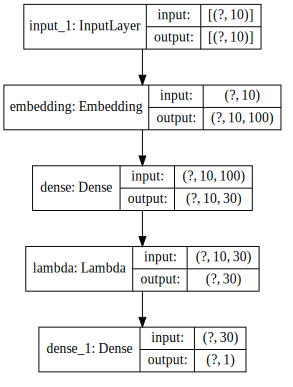

In [9]:
# model
model = get_deepset_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [10]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=100, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights.hdf5')

# save weights
deep_we = []
for i in [1,2,4]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

Epoch 1/100
772/772 [==============================] - 2s 3ms/step - loss: 0.4511 - val_loss: 0.4442
Epoch 2/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4471 - val_loss: 0.4445
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4469 - val_loss: 0.4450
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4472 - val_loss: 0.4475
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4469 - val_loss: 0.4472
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4469 - val_loss: 0.4443
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4470 - val_loss: 0.4443
Epoch 8/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4467 - val_loss: 0.4443
Epoch 9/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4468 - val_loss: 0.4444
Epoch 10/100
772/772 [==============================] - 1s 2ms/step - loss: 0.4468 - val_lo

# Train LSTM model

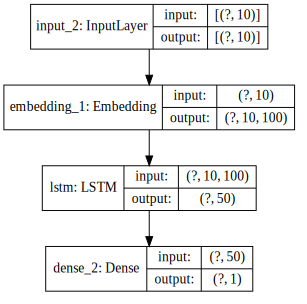

In [11]:
# model
model = get_lstm_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [12]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights1.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights1.hdf5')

# save weights
lstm_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Epoch 1/50
772/772 [==============================] - 8s 11ms/step - loss: 0.4636 - val_loss: 0.4446
Epoch 2/50
772/772 [==============================] - 9s 11ms/step - loss: 0.4449 - val_loss: 0.4425
Epoch 3/50
772/772 [==============================] - 9s 11ms/step - loss: 0.4427 - val_loss: 0.4403
Epoch 4/50
772/772 [==============================] - 9s 12ms/step - loss: 0.4382 - val_loss: 0.4351
Epoch 5/50
772/772 [==============================] - 8s 11ms/step - loss: 0.4252 - val_loss: 0.4168
Epoch 6/50
772/772 [==============================] - 8s 10ms/step - loss: 0.4039 - val_loss: 0.3970
Epoch 7/50
772/772 [==============================] - 10s 13ms/step - loss: 0.3720 - val_loss: 0.3519
Epoch 8/50
772/772 [==============================] - 10s 13ms/step - loss: 0.3295 - val_loss: 0.3158
Epoch 9/50
772/772 [==============================] - 9s 12ms/step - loss: 0.2880 - val_loss: 0.2522
Epoch 10/50
772/772 [==============================] - 9s 11ms/step - loss: 0.1761 - val_

# Train GRU model

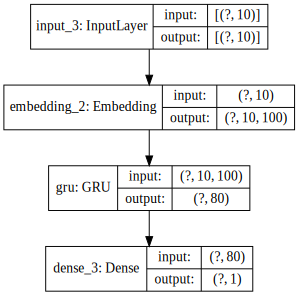

In [13]:
# model
model = get_gru_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [14]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
gru_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

Epoch 1/50
772/772 [==============================] - 10s 13ms/step - loss: 0.4566 - val_loss: 0.4431
Epoch 2/50
772/772 [==============================] - 9s 12ms/step - loss: 0.4431 - val_loss: 0.4393
Epoch 3/50
772/772 [==============================] - 9s 11ms/step - loss: 0.4269 - val_loss: 0.4016
Epoch 4/50
772/772 [==============================] - 9s 11ms/step - loss: 0.3671 - val_loss: 0.2677
Epoch 5/50
772/772 [==============================] - 9s 11ms/step - loss: 0.0296 - val_loss: 0.0032
Epoch 6/50
772/772 [==============================] - 9s 12ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 7/50
772/772 [==============================] - 10s 12ms/step - loss: 0.0026 - val_loss: 8.9062e-04
Epoch 8/50
772/772 [==============================] - 9s 11ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 9/50
772/772 [==============================] - 9s 12ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/50
772/772 [==============================] - 9s 12ms/step - loss: 0.0020 - 

# Evaluate models

In [23]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[], 'mae':[], 'mse':[]}, 'gru': {'acc':[], 'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in lengths:
    print('Evaluating at length: ', l)
    K.clear_session()
    
    # generate test data
    Y, sum_Y = gen_test_data(num_test_examples, l)

    # model
    model = get_deepset_model(l)

    # load weights
    for i, idx in enumerate([1,2,4]):
        print(len(deep_we[i][0]))
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    print(len(sum_Y))
    print(sum_Y)
    print(np.squeeze(np.round(preds)))
    print(np.squeeze(np.round(preds))==sum_Y)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['deepsets']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    break
    # model
    model = get_lstm_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        print(len(lstm_we[i][0]))
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['lstm']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_gru_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        print(len(gru_we[i][0]))
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['gru']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))

Evaluating at length:  5
2
100
30
79/79 [==============================] - 0s 1ms/step
10000
[1. 1. 1. ... 0. 1. 0.]
[1. 1. 1. ... 1. 1. 1.]
[ True  True  True ... False  True False]


Compare the performance

In [16]:
from matplotlib import rc
# activate latex text rendering
rc('text', usetex=True)
import matplotlib
# matplotlib.use('QT5Agg')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 14,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False,
})
matplotlib.rcParams['text.latex.preamble'] = r'\DeclareUnicodeCharacter{2212}{-}' #for \text command

import matplotlib.pyplot as plt

# font = {'size': 14}
# matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 95 )
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.savefig('DeepSetsLSTMGRU_XOR.pgf')
plt.show()

<ipython-input-16-e71ea491582d>:36: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [19]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mae'])/1e2, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean absolute error/1e2')
plt.title('MAE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.savefig('ds3.pgf')
plt.show()

<ipython-input-19-310af8785027>:16: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [20]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mse'])/1e5, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean square error/1e5')
plt.title('MSE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.savefig('ds4.pgf')
plt.show()

<ipython-input-20-c2d364923dc6>:16: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
